In [20]:
# Necessary imports

# hiding the warnings
import warnings

warnings.filterwarnings('ignore')
import os, sys

sys.stderr = open(os.devnull, "w")  # silence stderr
sys.stderr = sys.__stderr__  # unsilence stderr

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

# for better resolution plots
%config InlineBackend.figure_format = 'retina'

# hierarchical clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, MeanShift, DBSCAN, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram
from sklearn.base import clone
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.mixture import GaussianMixture

from minisom import MiniSom

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import Colorbar

# setting the style of seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Load Data

In [21]:
# Importing the dataset
df = pd.read_csv('Case1_HotelCustomerSegmentation_Preprocessed.csv', sep=',')
df.set_index('ID', inplace=True)

## Booking behavior Perspective

In [22]:
behav_cols = ['BookingConversionRate', 'AverageLeadTime_log', 'AvgPersonsPerBooking_log', 'TotalBookings_log']

## Hierarchical Clustering

In [23]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

### K-means and Hierarchical Clustering

In [24]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

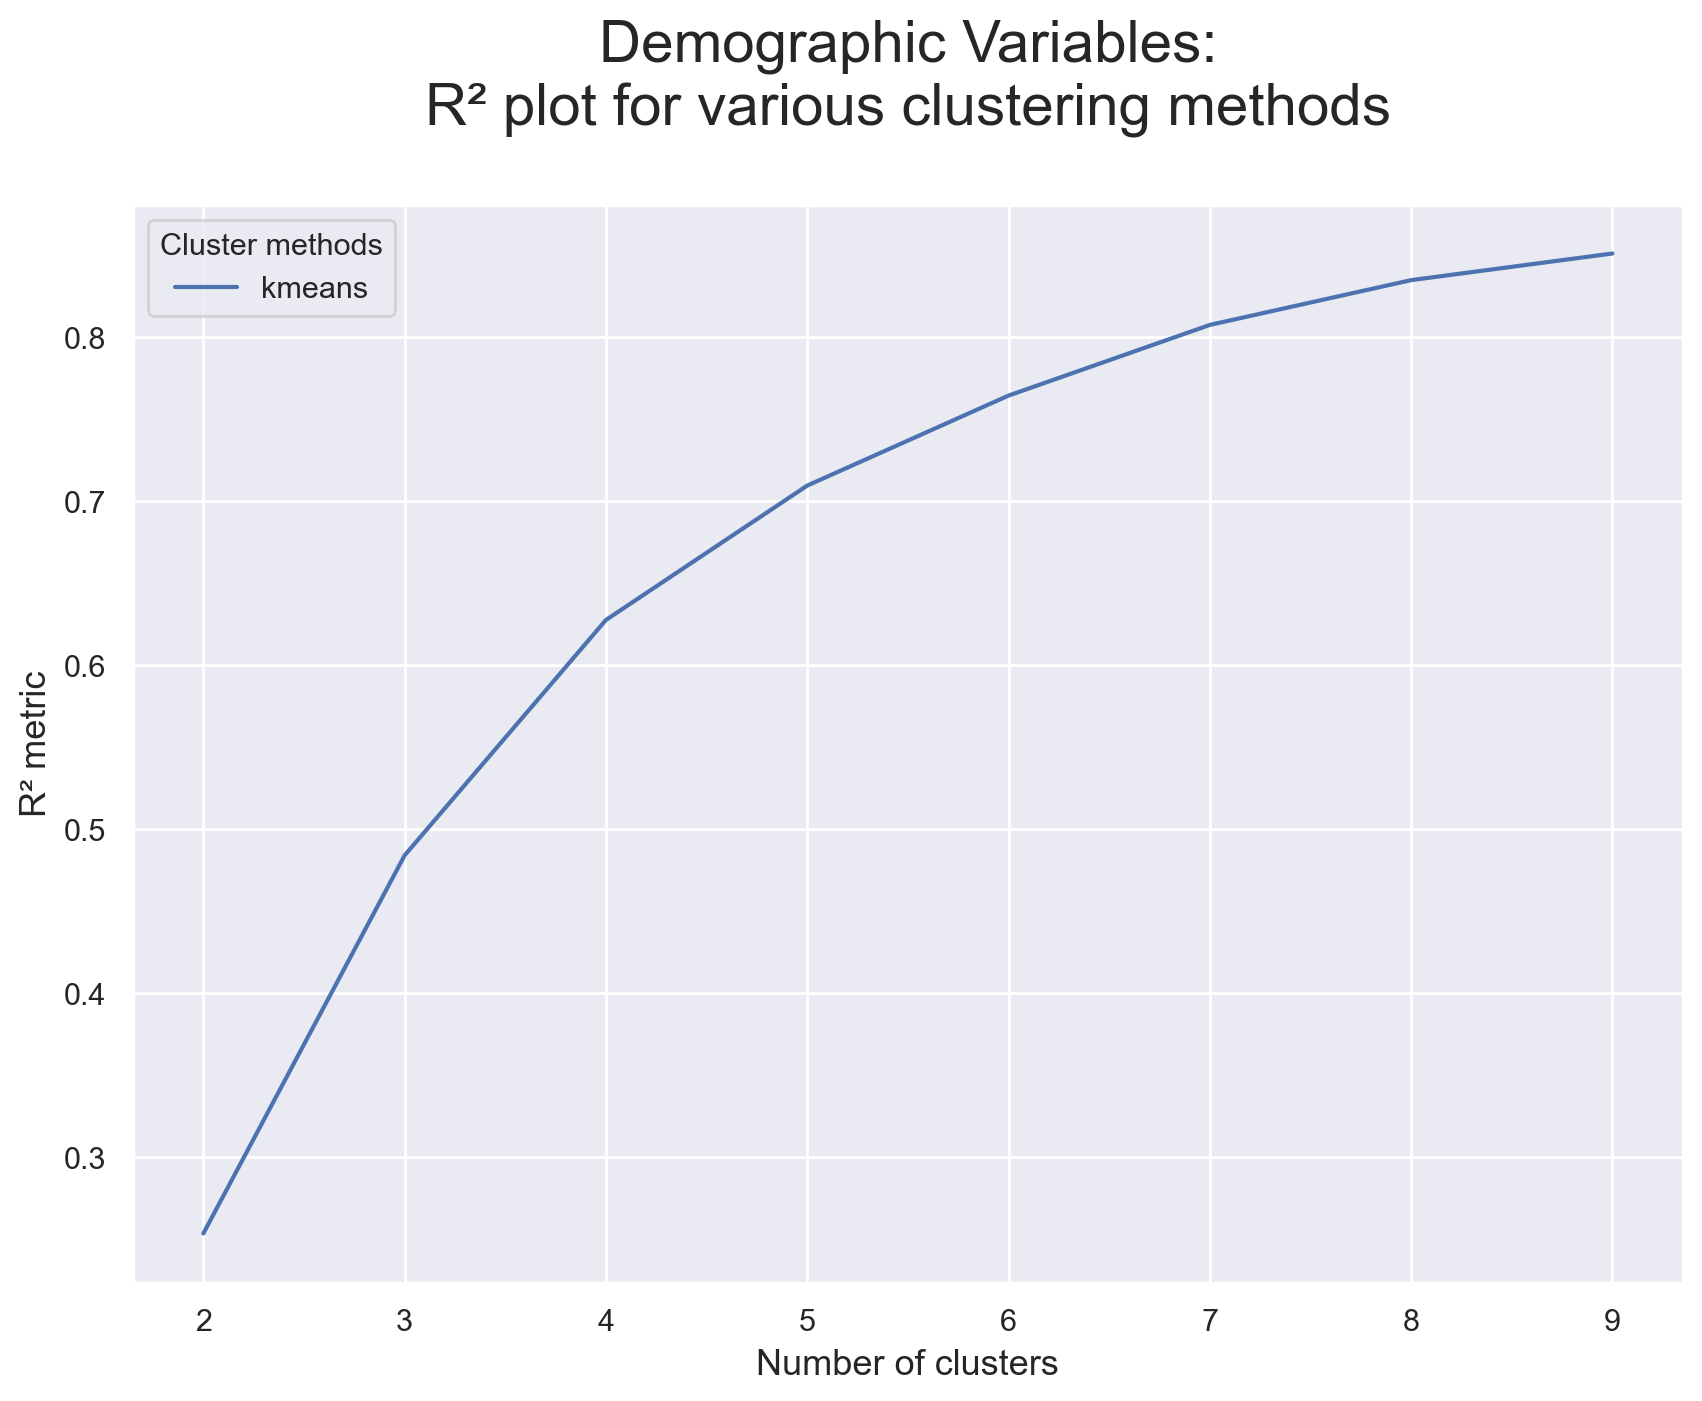

In [25]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df[behav_cols], kmeans)

# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

In [26]:
# Set up the clusterers
kmeans = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)

labels = kmeans.fit_predict(df[behav_cols])
print(f"The R2 is: {r2(df[behav_cols], labels)}")

The R2 is: 0.48419507511146476


### DBSCAN

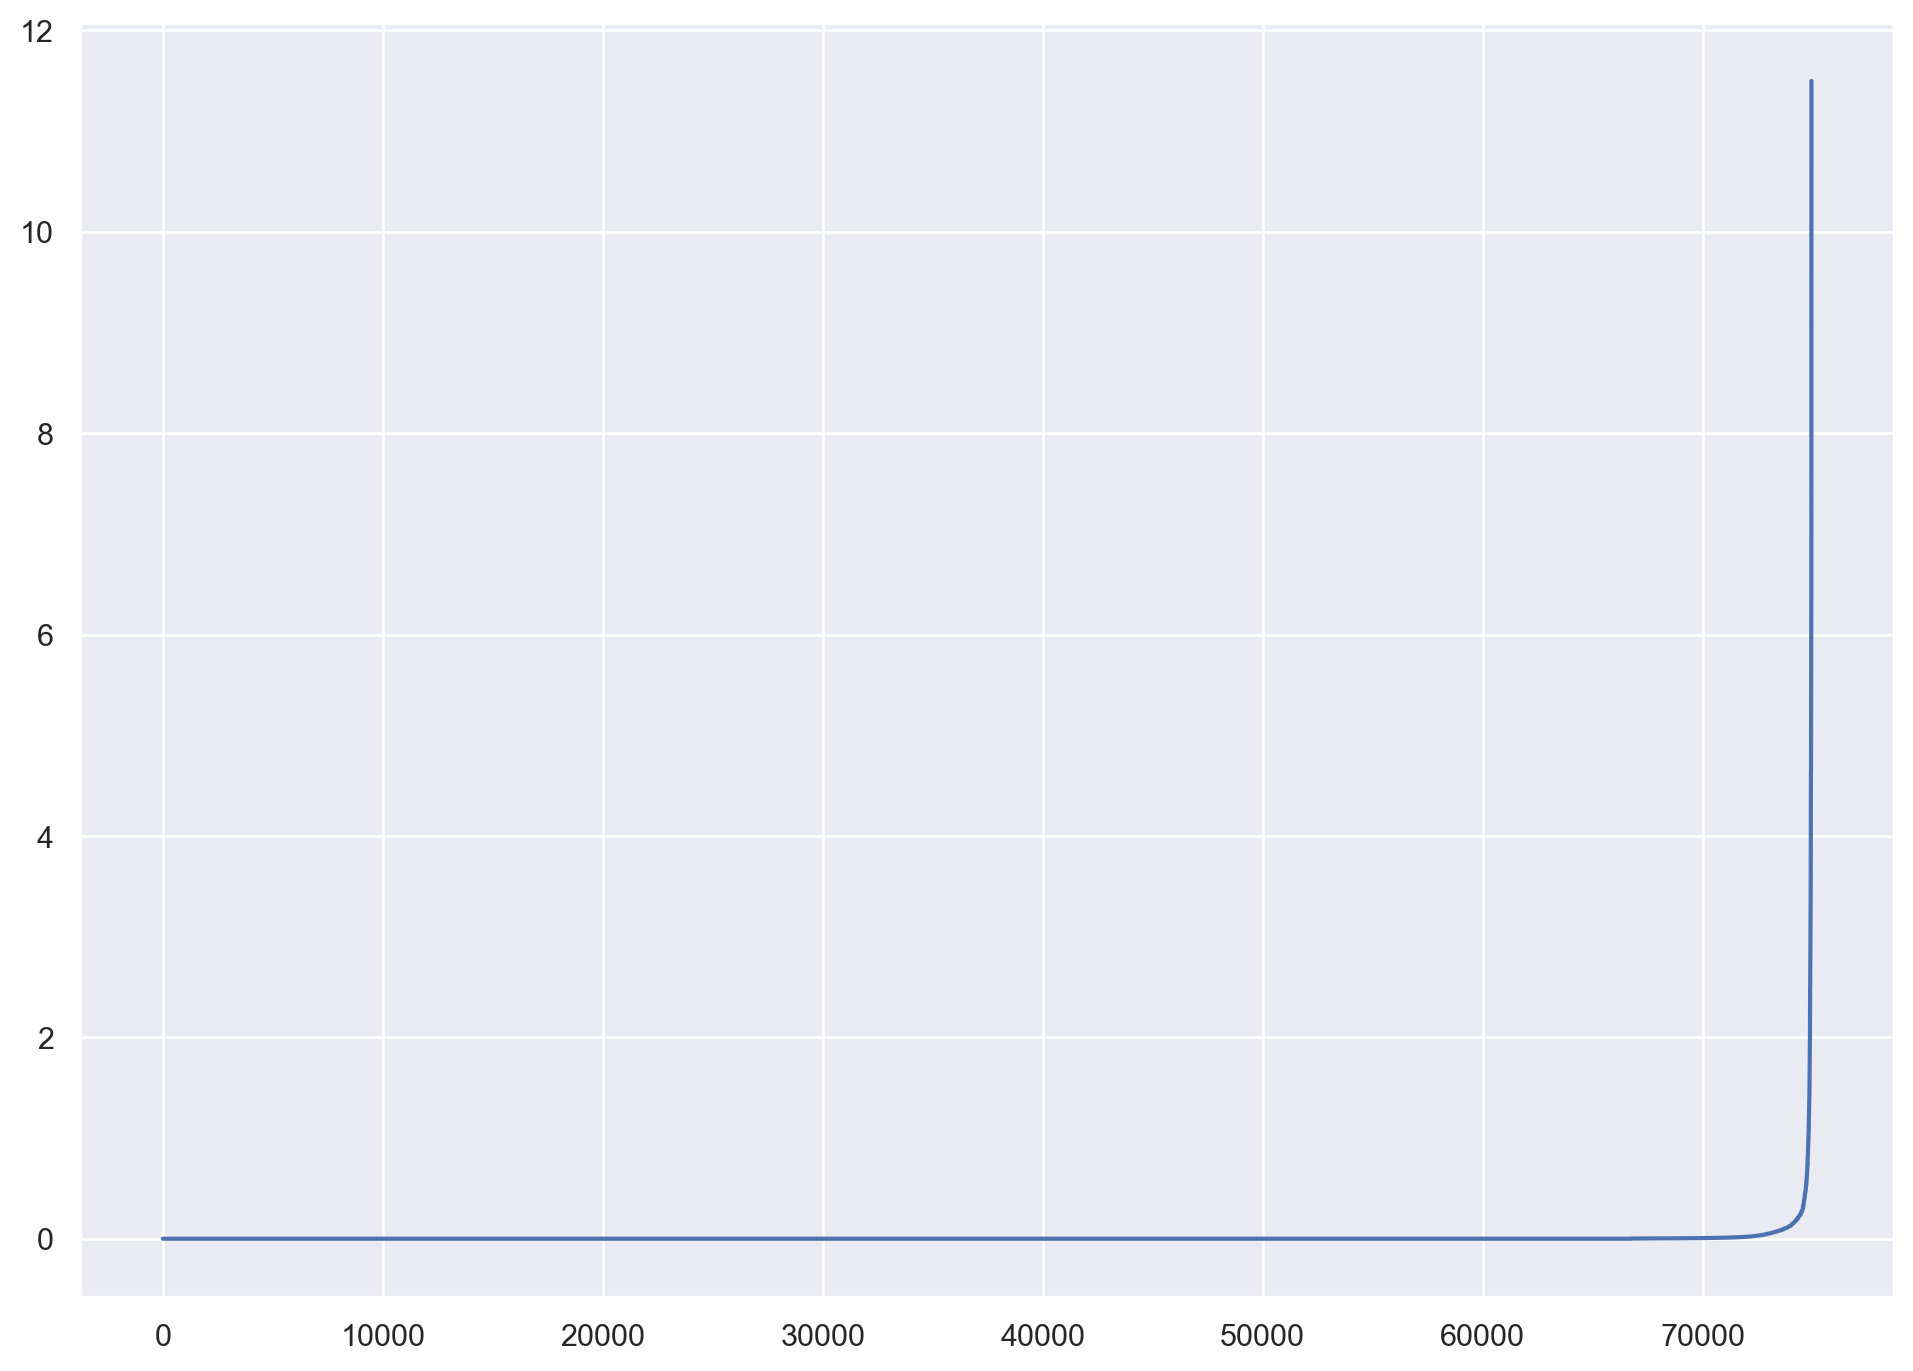

In [30]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=7)
neigh.fit(df[behav_cols])
distances, _ = neigh.kneighbors(df[behav_cols])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=1.0, min_samples=6, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df[behav_cols])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

## Spending Pattern Perspective